# A) Recursive GLS

### [A.1] Import Packages

In [31]:
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
from scipy.integrate import odeint

In [32]:
def get_batch(y, t, knots, iteration, mode):
    np.random.seed(iteration)
    print('\nseed= ',iteration)
    
    if mode == "single_uniform":
        idx = np.arange(0, t.shape[0], (t.shape[0]/knots))
        t_knots = np.array(t[idx])
        return t_knots#,idx
    
    elif mode == "single_random":
        idx = np.random.choice(len(t), size = knots, replace = False) 
        idx=np.sort(idx)
        t_knots = np.array(t[idx])
        #print(t_knots)
        return t_knots#,idx
    
    elif mode == "block_random":
        idx = np.random.choice(len(t), size = t.shape[0], replace = False) 
        t_knots = np.array(t[idx])
        return t_knots#,idx
    
    elif mode == "block_uniform":
        t_knots = np.array(t)
        return t_knots
    
    elif mode== "mid_point":
        idx = int(t.shape[0]/2)
#         idx= np.array([0,int(t.shape[0]/2),-1])
        t_knots = np.array(t[idx])
        return t_knots#, idx
    
    else:
        t_knots = np.array([])
        return t_knots
    
def get_tk(t_knots, iteration, mode):
    if mode == "single_uniform" or mode == "single_random" or mode=="mid_point":
        if t_knots.size==1:
            tk=t_knots
        else:
            tk = np.array([t_knots[iteration]])
        return tk
    
    elif mode == "block_uniform" or mode == "block_random":
        idx = np.arange((iteration)*knots,(iteration+1)*knots)
        tk = np.array(t_knots[idx])
        return tk
    

### [A.3] Get Tau Forward and Tau Backward

In [33]:
def get_tau(y, t, ti):
    F_indices = np.where(t <= ti)[0]
    B_indices = np.where(t > ti)[0]
    tau_F = t[F_indices]
    tau_B = t[B_indices]
    return tau_F, tau_B

### [A.4] Calculate Annihilator Terms

In [34]:
def get_alpha_tau(ti, tau_F, tau_B, a, b, n):
    f = np.math.factorial
    
    #Calculate alpha forward
    delta_time_F = np.array((ti - tau_F)**(n-1))
    delta_tau_F = np.array((tau_F - a)**4)
    alpha_F = np.multiply(delta_time_F, delta_tau_F)
    
    #Calculate alpha backward
    delta_time_B = np.array((ti - tau_B)**(n-1))
    delta_tau_B = np.array((b - tau_B)**4)
    alpha_B = np.multiply(delta_time_B, delta_tau_B)
    
    alpha = np.concatenate((alpha_F, alpha_B), axis = 0)
    alpha = np.array(alpha/f(n-1))
    return alpha

### [A.5] Calculate Kernels for Q and P Matrices

In [35]:
def get_KFn_vector(ti, tau_F, a, n):
    if tau_F.size == 1:
        tau_F = np.array([tau_F])
    N_tau = tau_F.shape[0]
    f = np.math.factorial
    gamma = np.zeros((4, N_tau))
    zeta = np.zeros((5, N_tau))
    delta = np.array(tau_F - a)
    
    for i in range(0, 4):
        gamma[i, :] = np.array(((ti - tau_F)**(n+i))/(f(n+i)))
        
    zeta[3, :] = np.array(gamma[0, :]*(-1.0)*(delta**4)
                          +gamma[1, :]*(12.0)*(delta**3)
                          +gamma[2, :]*(-36.0)*(delta**2)
                          +gamma[3, :]*(24.0)*(delta))
    
    zeta[2, :] = np.array(gamma[1, :]*(-1.0)*(delta**4)
                          +gamma[2, :]*(8.0)*(delta**3)
                          +gamma[3, :]*(-12.0)*(delta**2))
    
    zeta[1, :] = np.array(gamma[2, :]*(-1.0)*(delta**4)
                          +gamma[3, :]*(4.0)*(delta**3))
    
    zeta[0, :] = np.array(gamma[3, :]*(-1.0)*(delta**4))
    
    zeta[4, :] = np.array(gamma[0, :]*(16.0)*(delta**3)
                          +gamma[1, :]*(-72.0)*(delta**2)
                          +gamma[2, :]*(96.0)*(delta)
                          +gamma[3, :]*(-24.0)*(np.ones(N_tau)))
    
    return zeta



def get_KBn_vector(ti, tau_B, b, n):
    if tau_B.size == 1:
        tau_B = np.array([tau_B])
    N_tau = tau_B.shape[0]
    f = np.math.factorial
    gamma = np.zeros((4, N_tau))
    zeta = np.zeros((5, N_tau))
    delta = np.array(b - tau_B)
    
    #Santosh Derivation
    for i in range(0, 4):
        gamma[i, :] = np.array(((ti - tau_B)**(n+i))/(f(n+i)))
    
    
    zeta[3, :] = np.array(gamma[0, :]*(1.0)*(delta**4)
                          +gamma[1, :]*(12.0)*(delta**3)
                          +gamma[2, :]*(36.0)*(delta**2)
                          +gamma[3, :]*(24.0)*(delta))
    
    zeta[2, :] = np.array(gamma[1, :]*(1.0)*(delta**4)
                          +gamma[2, :]*(8.0)*(delta**3)
                          +gamma[3, :]*(12.0)*(delta**2))
    
    zeta[1, :] = np.array(gamma[2, :]*(1.0)*(delta**4)
                          +gamma[3, :]*(4.0)*(delta**3))
    
    zeta[0, :] = np.array(gamma[3, :]*(1.0)*(delta**4))
    
    zeta[4, :] = np.array(gamma[0, :]*(16.0)*(delta**3)
                          +gamma[1, :]*(72.0)*(delta**2)
                          +gamma[2, :]*(96.0)*(delta)
                          +gamma[3, :]*(24.0)*(np.ones(N_tau)))
    
    if n > 0:
        zeta = np.array(-1.0*zeta)
    return zeta
    

### [A.6] Calculate Kernels for S Matrix

In [36]:
def get_KDSn(ti, tau_F, tau_B, a, b, n, ak):
    print(f"ak is {ak} in get_KDSn")

    beta = np.concatenate((ak, 1), axis = None)
    beta = beta.reshape(5,1)
    
    KFn_vector = get_KFn_vector(ti, tau_F, a, n)
    KBn_vector = get_KBn_vector(ti, tau_B, b, n)
    KDSn_vector = np.concatenate((KFn_vector, KBn_vector), axis = 1)
    
    KDSn = np.multiply(beta, KDSn_vector)
    KDSn = np.sum(KDSn, axis = 0)
    return KDSn

def get_KFn(ti, tau_F, a, n, ak):
    beta = np.concatenate((ak, 1), axis = None)
    beta = beta.reshape(5,1)
    
    KFn_vector = get_KFn_vector(ti, tau_F, a, n)
    KFn = np.multiply(beta, KFn_vector)
    KFn = np.sum(KFn, axis = 0)
    return KFn

def get_KBn(ti, tau_B, b, n, ak):
    beta = np.concatenate((ak, 1), axis = None)
    beta = beta.reshape(5,1)
    
    KBn_vector = get_KBn_vector(ti, tau_B, b, n)
    KBn = np.multiply(beta, KBn_vector)
    KBn = np.sum(KBn, axis = 0)
    return KBn

### [A.7] Calculate LHS

In [37]:
def get_LHS(y, t, tk, a, b, n):
    f = np.math.factorial
    
    if tk.size!=1:
        N = tk.shape[0]
    elif tk.size==1:
        N=1
    #print('\nstart time ',tk)
    
    LHS_n = np.zeros(N)
    r = 0
    print(f"tk is {tk}")
    if(tk.size==1):
        ti=tk
        tau_F, tau_B = get_tau(y, t, ti)

        #Calculate alpha
        alpha = get_alpha_tau(ti, tau_F, tau_B, a, b, n)

        #Calculate Integrand:
        integrand = np.multiply(alpha, y)

        #Integrate
        integral = np.trapz(integrand, t)

        #Store value
        LHS_n[r] = np.array((integral))
    else:
        for ti in tk:

            tau_F, tau_B = get_tau(y, t, ti)

            #Calculate alpha
            alpha = get_alpha_tau(ti, tau_F, tau_B, a, b, n)

            #Calculate Integrand:
            integrand = np.multiply(alpha, y)

            #Integrate
            integral = np.trapz(integrand, t)

            #Store value
            LHS_n[r] = np.array((integral))
            r += 1
    
    return LHS_n


### [A.8] Calculate RHS

In [38]:
def get_RHS(y, t, tk, a, b, n):
    f = np.math.factorial
    if tk.size!=1:
        N = tk.shape[0]
    elif tk.size==1:
        N=1
    print('start time ',tk)
    
    RHS_n = np.zeros((N, 5))
    
    r = 0
    
    if(tk.size==1):
        ti=tk
        tau_F, tau_B = get_tau(y, t, ti)

        #Calculate Kernel vector
        KFn_vector = get_KFn_vector(ti, tau_F, a, n)
        KBn_vector = get_KBn_vector(ti, tau_B, b, n)
        KDSn_vector = np.concatenate((KFn_vector, KBn_vector), axis = 1)

        #Calculate integrands
        integrand = np.multiply(KDSn_vector, y)

        #Integrate
        for k in range(0, 5):
            RHS_n[r, k] = np.trapz(integrand[k, :], t)
    else:
        for ti in tk:
            tau_F, tau_B = get_tau(y, t, ti)

            #Calculate Kernel vector
            KFn_vector = get_KFn_vector(ti, tau_F, a, n)
            KBn_vector = get_KBn_vector(ti, tau_B, b, n)
            KDSn_vector = np.concatenate((KFn_vector, KBn_vector), axis = 1)

            #Calculate integrands
            integrand = np.multiply(KDSn_vector, y)

            #Integrate
            for k in range(0, 5):
                RHS_n[r, k] = np.trapz(integrand[k, :], t)

            r += 1

    return RHS_n

### [A.9] Calculate Q and P matrices

In [39]:
def get_P_Q(y, t, tk, a, b, n_max,plot=False):
    f = np.math.factorial
    
    n_min=n_max-4
    n_vector = np.arange(n_min, n_max)
    
    for n in n_vector:
        print('\n n= ',n)
        
        LHS_n = get_LHS(y, t, tk, a, b, n)
        RHS_n = get_RHS(y, t, tk, a, b, n)
        
        if n == n_vector[0]:
            LHS = np.array(LHS_n)
            RHS = np.array(RHS_n)
        else:
            LHS = np.concatenate((LHS, LHS_n), axis = None)
            RHS = np.vstack((RHS, RHS_n))
    

    #Arrange P:
    P = np.array(RHS[:, 0:4])
    #Arrange Q:
    Q = np.subtract(LHS, RHS[:, 4])
    
    
    if plot==True:
        plt.figure(figsize=(10,7))
        for i in range (1,n_max-n_min+1):
            lab='n= '+str(n_min-1+i)
            plt.plot(tk,LHS[knots*(i-1):knots*i]-(RHS[knots*(i-1):knots*i,0]*1+RHS[knots*(i-1):knots*i,1]*5+RHS[knots*(i-1):knots*i,2]*5+RHS[knots*(i-1):knots*i,3]*0+RHS[knots*(i-1):knots*i,4]),label=lab)
            plt.legend(loc='best')
        
        print('\nParameter Estimates for individual eqns')
        for i in range(1,n_max-n_min+1):
            print('\nn= ',n_min-1+i)
            print( np.matmul(np.linalg.pinv(P[knots*(i-1):knots*i]), Q[knots*(i-1):knots*i]))
            
        plt.figure(figsize=(25,10))
        chart=1
        for i in range(1,n_max-n_min+1):
            plt.subplot(n_max-n_min+1,5, chart)
            lab='a3_RHS_'+str(n_min-1+i)
            plt.plot(tk, RHS[knots*(i-1):knots*i,0], 'b', label=lab)
            plt.legend(loc='best')
            chart+=1
            plt.subplot(n_max-n_min+1, 5, chart)
            lab='a2_RHS_'+str(n_min-1+i)
            plt.plot(tk, RHS[knots*(i-1):knots*i,1], 'g', label=lab)
            plt.legend(loc='best')
            chart+=1
            plt.subplot(n_max-n_min+1, 5, chart)
            lab='a1_RHS_'+str(n_min-1+i)
            plt.plot(tk, RHS[knots*(i-1):knots*i,2], 'r', label=lab)
            plt.legend(loc='best')
            chart+=1
            plt.subplot(n_max-n_min+1, 5, chart)
            lab='a0_RHS_'+str(n_min-1+i)
            plt.plot(tk, RHS[knots*(i-1):knots*i,3], 'm', label='a0_RHS_1')
            plt.legend(loc='best')
            chart+=1
            plt.subplot(n_max-n_min+1, 5, chart)
            lab='const_RHS_'+str(n_min-1+i)
            plt.plot(tk, RHS[knots*(i-1):knots*i,4], 'm', label=lab)
            plt.legend(loc='best')
            chart+=1
            
    return P, Q

In [40]:
%%time
def gaussian_noise(y, t, mean, std):
    noise = np.random.normal(mean, std, t.shape[0])
    ynoise = np.array(y + noise)
    #ynoise = y + noise
    return ynoise

#P, Q = PQ(y, t, a, b, knots,iteration)
knots=3
ynoise = gaussian_noise(y, t, 0, 1)
iteration=0
t_knots_trial = get_batch(y, t, knots, iteration, mode='mid_point')
print(t_knots_trial)
tk = get_tk(t_knots_trial, iteration, mode='mid_point')


ValueError: operands could not be broadcast together with shapes (60000,) (200000,) 

In [41]:
P, Q = get_P_Q(ynoise, t, t_knots_trial, a, b, n_max=7,plot=False)
#PQ(ynoise, t, a, b, knots,iteration)
Pin = np.linalg.pinv(P)
a_est = np.matmul(Pin, Q)
print('\n')
print(P.shape)
print(Q.shape)
print(a_est)


 n=  3
tk is 3.0000150000750003
start time  3.0000150000750003

 n=  4
tk is 3.0000150000750003
start time  3.0000150000750003

 n=  5
tk is 3.0000150000750003
start time  3.0000150000750003

 n=  6
tk is 3.0000150000750003
start time  3.0000150000750003


(4, 4)
(4,)
[39.42832075 -4.08874923 17.2075015   0.53368894]


### [A.10] Calculate S Matrix

In [42]:
#Diagonal Covariance Matrix
def get_S(y, t, tk, a, b, ak, n_max, var): 
    
    f = np.math.factorial
    
    if(tk.size==1):
        N=1
    else:
        N = tk.shape[0]
    
    n_vector = np.arange(n_max - 4, n_max)
    
    S = np.zeros(((n_vector.shape[0])*N, (n_vector.shape[0])*N))
    
    m = 0
    for n in n_vector:
        Cov_inv = np.zeros((N, N))
        
        r1 = 0
        if(tk.size==1):
            ti=tk
            tau_F, tau_B = get_tau(y, t, ti)

            KDSn = get_KDSn(ti, tau_F, tau_B, a, b, n, ak)
            alpha = get_alpha_tau(ti, tau_F, tau_B, a, b, n)
            integrand = np.array((alpha - KDSn)**2)

            Cov = np.array((var**2)*(np.trapz(integrand, t)))
            Cov_inv[r1,r1] = np.array(1/Cov) #np.linalg.inv(Cov) #np.array(1/Cov)-Shantanil
            #print('**r1**\n',r1)
            #print('***Cov***\n',Cov)
            #print('******\n\n')
            r1 += 1
        else:
            for ti in tk:
                tau_F, tau_B = get_tau(y, t, ti)

                KDSn = get_KDSn(ti, tau_F, tau_B, a, b, n, ak)
                alpha = get_alpha_tau(ti, tau_F, tau_B, a, b, n)
                integrand = np.array((alpha - KDSn)**2)

                Cov = np.array((var**2)*(np.trapz(integrand, t)))
                Cov_inv[r1,r1] = np.array(1/Cov) #np.linalg.inv(Cov) #np.array(1/Cov)-Shantanil
                #print('**r1**\n',r1)
                #print('***Cov***\n',Cov)
                #print('******\n\n')
                r1 += 1
        
        S[(m)*N: (m+1)*N, (m)*N: (m+1)*N] = np.array(Cov_inv)
        
        m += 1
    print('\n***S (Diagonal_Covariance)***\n',S)
    print('******\n\n')    
    return S

#Full Covariance Matrix
def get_S1(y, t, tk, a, b, ak, n_max, var):
    f = np.math.factorial
        
    N = tk.shape[0]
    N_ext = t.shape[0]
    n_vector = np.arange(n_max - 4, n_max)
    
    S = np.zeros(((n_vector.shape[0])*N, (n_vector.shape[0])*N))
    
    m = 0
    for n in n_vector:
        Cov = np.zeros((N, N))
        KDSn_tau = np.zeros((N, N_ext))
        alpha = np.zeros((N, N_ext))
        
        r1 = 0
        for ti in tk:
            tau_F, tau_B = get_tau(y, t, ti)

            KDSn_tau[r1, :] = get_KDSn(ti, tau_F, tau_B, a, b, n, ak)

            alpha[r1, :] = get_alpha_tau(ti, tau_F, tau_B, a, b, n)

            r1 += 1

        for r1 in range(0, N):
            for r2 in range(r1, N):
                #Get first term of the E(e^n*e^n)
                Cov1 = np.multiply(alpha[r1, :], alpha[r2, :])
                #Get second term of the E(e^n*e^n)
                Cov2 = np.multiply(alpha[r1, :], KDSn_tau[r2, :])
                #Get third term of the E(e^n*e^n)
                Cov3 = np.multiply(alpha[r2, :], KDSn_tau[r1, :])
                #Get fourth term of the E(e^n*e^n)
                Cov4 = np.multiply(KDSn_tau[r1, :], KDSn_tau[r2, :])

                #Since all of these terms have the same differential, they can be integrated all together.
                integrand = np.array((var**2)*(Cov1 - Cov2 - Cov3 + Cov4))

                Cov[r1, r2] = np.trapz(integrand, t)

                #Setup symmetry
                Cov[r2, r1] = np.array(Cov[r1, r2])

        #Concatenate results:
        S[(m)*N : (m+1)*N, (m)*N : (m+1)*N] = np.linalg.inv(Cov)
        m += 1
    
    return S

### [A.11] Reconstruct yE(t)

In [43]:
def get_fund_eqtns(y, t, ak):
    canon = np.array([[0.0, 1.0, 0.0, 0.0],
                [0.0, 0.0, 1.0, 0.0],
                [0.0, 0.0, 0.0, 1.0]])

    ak = ak.reshape(1, 4)
    canon = np.vstack((canon, -1.0*ak))
    
    w, v = np.linalg.eig(canon)
    w_ext = np.zeros((4,2))
    for i in range(0, 4):
        w_ext[i, 0] = np.real(w[i])
        w_ext[i, 1] = np.abs(np.imag(w[i]))
    #Separate Repeated Roots:
    unique = np.sort(np.unique(w_ext, return_index=True, axis = 0)[1])
    roots = {}
    n = 0
    for i in unique:
        w_i = w_ext[i, :]

        #Find repeated real roots
        if w_i[1] < 0.01:
            idx_repeated = np.where(w_i[0] == w_ext[:,0])[0]
            roots[n] = np.array(w_ext[idx_repeated,:])
        else:
            idx_r_repeated = np.where(w_i[0] == w_ext[:,0])[0]
            idx_c_repeated = np.where(w_i[1] == w_ext[:,1])[0]
            idx_repeated = idx_r_repeated[np.where(idx_r_repeated == idx_r_repeated)[0]]    
            roots[n] = np.array(w_ext[idx_repeated])
        n += 1

    #Calculate Fundamental Solutions:
    eta = np.zeros((4, t.shape[0]))
    i = 0
    for n in range(0, len(roots)):
        root_n = np.array(roots[n])
        if root_n.shape[0] == 1:
            eta[i, :] = np.array(np.exp(root_n[0,0]*t))
            i += 1
        elif root_n.shape[0] == 2:
            if root_n[0,1] < 0.01:
                exp = np.exp(root_n[0,0]*t)
                eta[i, :] = np.array(exp)
                i += 1
                eta[i, :] = np.multiply(t, exp)
                i += 1
            else:
                real = np.array(root_n[0,0])
                imag = np.array(root_n[0,1])
                exp = np.exp(real*t)
                eta[i, :] = np.multiply(exp, np.cos(imag*t))
                i += 1
                eta[i, :] = np.multiply(exp, np.sin(imag*t))
                i += 1
        elif root_n.shape[0] == 3:
            exp = np.exp(root_n[0,0]*t)
            eta[i, :] = np.array(exp)
            i += 1
            eta[i, :] = np.multiply(t, exp)
            i += 1        
            eta[i, :] = np.multiply(t**2, exp)
            i += 1                
        elif root_n.shape[0] == 4:
            if root_n[0,1] < 0.01:
                exp = np.exp(root_n[0,0]*t)
                eta[i, :] = np.array(exp)
                i += 1
                eta[i, :] = np.multiply(t, exp)
                i += 1        
                eta[i, :] = np.multiply(t**2, exp)
                i += 1
                eta[i, :] = np.multiply(t**3, exp)
                i += 1
            else:
                real = np.array(root_n[0,0])
                imag = np.array(root_n[0,1])
                exp = np.exp(real*t)
                texp = np.multiply(t, exp)
                eta[i, :] = np.multiply(exp, np.cos(imag*t))
                i += 1
                eta[i, :] = np.multiply(exp, np.sin(imag*t))
                i += 1 
                eta[i, :] = np.multiply(texp, np.cos(imag*t))
                i += 1
                eta[i, :] = np.multiply(texp, np.sin(imag*t))
                i += 1 
    return eta

#Define L2 inner product
def L2p(f, g, t):
    integrand = np.multiply(f, g)
    integral = np.trapz(integrand, t)
    return integral

#Orthonormalize the fundamental equations
def orthonormalize(eta, t):
    N = t.shape[0]
    v = np.zeros((4, N))
    u = np.zeros((4, N))
    
    v[0, :] = np.array(eta[0, :])
    
    v[1, :] = np.array(eta[1, :] 
                       - ((L2p(eta[1, :], v[0, :], t)/L2p(v[0, :], v[0, :], t))*v[0, :]))

    v[2, :] = np.array(eta[2, :] 
                       - ((L2p(eta[2, :], v[0, :], t)/L2p(v[0, :], v[0, :], t))*v[0, :])
                      - ((L2p(eta[2, :], v[1, :], t)/L2p(v[1, :], v[1, :], t))*v[1, :]))
    
    v[3, :] = np.array(eta[3, :] 
                       - ((L2p(eta[3, :], v[0, :], t)/L2p(v[0, :], v[0, :], t))*v[0, :])
                      - ((L2p(eta[3, :], v[1, :], t)/L2p(v[1, :], v[1, :], t))*v[1, :])
                       - ((L2p(eta[3, :], v[2, :], t)/L2p(v[2, :], v[2, :], t))*v[2, :]))
    
    for i in range(0, 4):
        u[i, :] = np.array(v[i, :]/np.sqrt(L2p(v[i, :], v[i, :], t)))
    
    return u

#Reconstruct yE(t)
def get_yE(y, t, ak):
    N = t.shape[0]
    yE = np.zeros((4, N))
    
    #Get orthonormal vectors
    eta = get_fund_eqtns(y, t, ak)
    print("eta",eta)
    u = orthonormalize(eta, t)
    print("u:",u)
    inner_prod = np.zeros(4)
    for i in range(0, 4):
        inner_prod[i] = L2p(y, u[i, :], t)
        yE[i, :] = np.array(inner_prod[i]*u[i, :])
    yE = np.sum(yE, axis = 0)
    return yE

# OLS for Initial Estimation

In [44]:
def OLS(y, t, a, b, knots, n_max):
    #Find identifiable points
    z = 0
    for k in range(0, t.shape[0]):
        if z == knots:
            break
        P, Q = get_P_Q(y, t, a, b, 1, k, "random", n_max)
        if np.abs(np.linalg.det(P)) > 1.0:
            if z == 0:
                tk = np.array(get_batch(y, t, 1, k, "random")[0])
                idx = np.where(t == tk)[0]
                yk = np.array(y[idx])
                Ptotal = np.array(P)
                Qtotal = np.array(Q)
            else:
                ti = np.array(get_batch(y, t, 1, k, "random")[0])
                idx = np.where(t == ti)[0]
                yi = np.array(y[idx])
                tk = np.concatenate((tk, ti), axis = None)
                yk = np.concatenate((yk, yi), axis = None)
                Ptotal = np.concatenate((Ptotal, P), axis = 0)
                Qtotal = np.concatenate((Qtotal, Q), axis = None)
            z +=1

    a_OLS = np.matmul(np.linalg.pinv(Ptotal), Qtotal)
    return a_OLS

# RLS with Identifiable Point Search

In [45]:
def initial_Rk(P, S):
    #Calculate initial Rk
    PT = np.transpose(P)
    PTS = np.matmul(PT, S)
    Mk1 = np.matmul(PTS, P)
    Rk = np.linalg.inv(Mk1)
    return Rk


def get_Rk1(P, S, Rk):
    #Calculate r_1 = (S^-1 + P*Rk*PT)^-1
    PT = np.transpose(P)
    S_inv = np.linalg.inv(S)
    RPT = np.matmul(Rk, PT)
    PRPT = np.matmul(P, RPT)
    r_1 = np.add(S_inv, PRPT)
    r_1 = np.linalg.inv(r_1)
    
    #Calculate r_2 = Rk*PT*r_1 =Rk*PT*(S^-1 + P*Rk*PT)^-1
    r_2 = np.matmul(RPT, r_1)
    
    #Calculate r_3 = r_2*P*Rk =Rk*PT*(S^-1 + P*Rk*PT)^-1*P*Rk
    PR = np.matmul(P, Rk)
    r_3 = np.matmul(r_2, PR)
    
    #Calculate Rk1
    Rk1 = np.subtract(Rk, r_3)
    
    return Rk1


def get_ak1(Q, P, S, ak, Rk1):
    #Calculate a_1 = (Q - P*ak)
    Pa = np.matmul(P, ak)
    a_1 = np.subtract(Q, Pa)
    
    #Calculate a_2 = Rk1*PT*S
    PT = np.transpose(P)
    PTS = np.matmul(PT, S)
    a_2 = np.matmul(Rk1, PTS)
    
    #Calculate a_3 = a_2*a_1 = Rk1*PT*S*(Q - P*ak)
    a_3 = np.matmul(a_2, a_1)
    
    #Calculate ak1
    ak1 = np.add(ak, a_3)
    
    return ak1

In [46]:
def RLS(y, t, a, b, knots, mode, n_max, tol, ak_init):
    #Set initial iteration
    iteration = 0
    eps = np.inf
    
    #Define Time Points:
    t_knots = get_batch(y, t, knots, iteration, mode)
    print('\n t_knots= ',t_knots)
    
    if t_knots.size == 0:
        print("WARNING! ALGORITHM STOPPED: Mode name incorrectly specified")
        ak, ak_log = None, None
        return ak, ak_log
    
    #Set initial conditions
#     ak = np.array([0.0, 0.0, 0.0, 0.0])
    ak=ak_init
    #Store parameter estimation per iteration
    ak_log = np.array(ak)
    
    print(iteration, ak)
    
    while tol < eps:
        
        #Get knots used in current iteration
        tk = get_tk(t_knots, iteration, mode)
        print('\n tk= ',tk)
        P, Q = get_P_Q(y, t, tk, a, b, n_max)
        
        #Calculate S matrix
        yE = get_yE(y, t, ak)
        var = np.var(y - yE) #Variance Calculation
        
        S = get_S(y, t, tk, a, b, ak, n_max, var)
        #S = np.identity(P.shape[0])
        
        if iteration == 0:
            Rk  = initial_Rk(P, S)
        else:
            Rk = get_Rk1(P, S, Rk)
            
        ak1 = get_ak1(Q, P, S, ak, Rk)    
    
        eps = np.linalg.norm(ak1 - ak, np.inf)
        
        #Set next iteration
        iteration += 1
        ak = np.array(ak1)
        
        #Store parameter estimation per iteration
        ak_log = np.vstack((ak_log, ak))
        print(iteration, ak)
        
        #Max iteration:
        if iteration == knots:
            return ak, ak_log
        
    return ak, ak_log

# B) 4th Order Linear System

### [B.1] Add White Gaussian Noise

In [47]:
def add_AWGN(y, t, std):
    mu = np.inf
    while 0.00001 < mu:
        N = t.shape[0]    
        noise = np.random.normal(0, std, size = N)
        mu = np.abs(np.mean(noise))
    yM = np.array(y + noise)
    return yM

### [B.2] 4th Order Homogeneus LTI System Modeling

In [48]:
def states_system(a, b, points, x0, aT, std):    
    #Model 4th Order System
    def model(x,t):
        x1 = x[0]
        x2 = x[1]
        x3 = x[2]
        x4 = x[3]
        dx1dt = x2**3
        dx2dt = x3
        dx3dt = x4
        dx4dt = (-aT[0])*(x1) + (-aT[1])*(x2) + (-aT[2])*(x3) + (-aT[3])*x4
        dxdt = [dx1dt, dx2dt, dx3dt, dx4dt]
        return dxdt

    #Solve ODE
    def solve_ODE(t, x0, T):
        yT = np.empty_like(t)
        dyT = np.empty_like(t)
        ddyT = np.empty_like(t)
        dddyT = np.empty_like(t)
        yT[0] = x0[0] #set initial condition 
        dyT[0] = x0[1]
        ddyT[0] = x0[2]
        dddyT[0] = x0[3]
        for i in range(1,T):
            t_span = [t[i-1], t[i]]
            x = odeint(model, x0, t_span)
            yT[i] = x[1][0] #Store solution
            dyT[i] = x[1][1]
            ddyT[i] = x[1][2]
            dddyT[i] = x[1][3]
            x0 = x[1] #Next initial condition
        return yT, dyT, ddyT, dddyT
    
    t = np.linspace(a, b, points)
    y, dy, ddy, dddy = solve_ODE(t,x0, points)
    yM = add_AWGN(y, t, std)
    return yM, y, t


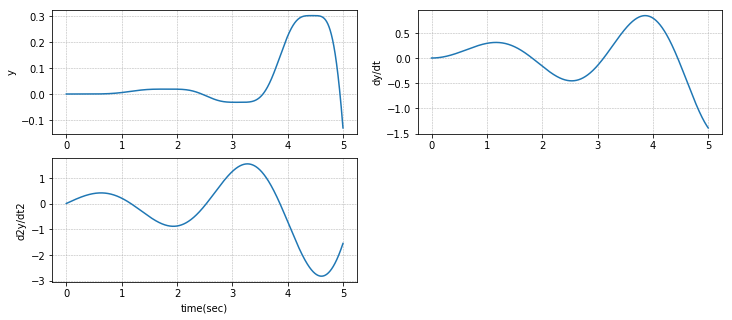

In [80]:
def model(x,t):
    aT = np.array([1.0, 5.0, 5.0, 0.0])
    x1 = x[0]
    x2 = x[1]
    x3 = x[2]
    x4 = x[3]
    dx1dt = x2**3
    dx2dt = x3
    dx3dt = x4
    dx4dt = (-aT[0])*(x1) + (-aT[1])*(x2) + (-aT[2])*(x3) + (-aT[3])*x4
    dxdt = [dx1dt, dx2dt, dx3dt, dx4dt]
    return dxdt

knots = 1
a = 0
b = 5#2
t = np.linspace(a, b, 60000) 
x0 = [0.0, 0.0,0.0, 1.0]
# x0 = [0.0, 5.0, 0.0]
xsol = odeint(model,x0,t)
y = xsol[:, 0]
ydot = xsol[:, 1]
ydotdot = xsol[:, 2]
plt.figure(figsize=(12,5))
plt.subplot(221)
plt.plot(t,y)
plt.ylabel('y')
plt.grid(linestyle = '--', linewidth = 0.5)
plt.subplot(222)
plt.plot(t,ydot)
plt.ylabel('dy/dt')
plt.grid(linestyle = '--', linewidth = 0.5)
plt.subplot(223)
plt.plot(t,ydotdot)
plt.xlabel('time(sec)')
plt.ylabel('d2y/dt2')
plt.grid(linestyle = '--', linewidth = 0.5)
plt.show()

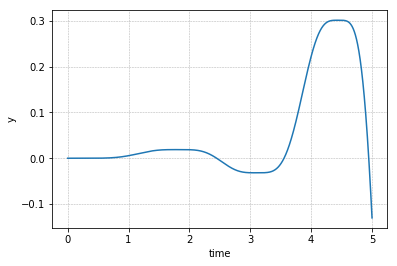

In [72]:
plt.figure()
plt.plot(t,y)
plt.ylabel('y')
plt.xlabel('time')
plt.grid(linestyle = '--', linewidth = 0.5)
plt.show()

In [100]:
y_dot_new = np.empty_like(ydot)
y_dot_new[:] = ydot

y_ddot_new = np.empty_like(ydotdot)
y_ddot_new[:] = ydotdot


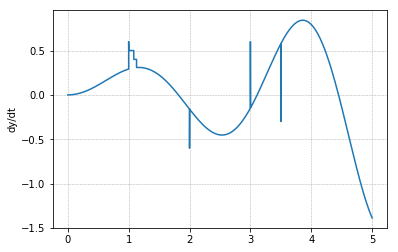

In [101]:
y_dot_new[0] = 0
y_dot_new[12000] = 0.6
y_dot_new[12002:13000] = 0.5
y_dot_new[13000:13555] = 0.4
y_dot_new[3*12000] = 0.6
y_dot_new[42000] =-0.3
y_dot_new[24000] = -0.6
plt.figure()
plt.plot(t,y_dot_new, label='estimated')
# plt.plot(t,ydot, label='true')
plt.ylabel('dy/dt')
plt.grid(linestyle = '--', linewidth = 0.5)
# plt.legend()
plt.show()

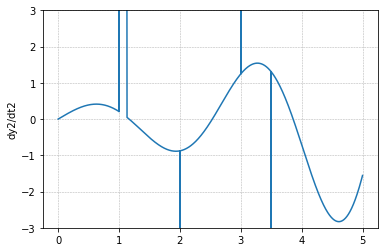

In [108]:
y_dot_new[0] = 0
y_ddot_new[12000] = 40
y_ddot_new[12002:13000] = 30
y_ddot_new[13000:13555] = 60
y_ddot_new[3*12000] = 20
y_ddot_new[42000] =-40
y_ddot_new[24000] = -50
plt.figure()
plt.plot(t,y_ddot_new, label='estimated')
# plt.plot(t,ydot, label='true')
plt.ylabel('dy2/dt2')
plt.grid(linestyle = '--', linewidth = 0.5)
plt.ylim(-3,3)
# plt.legend()
plt.show()

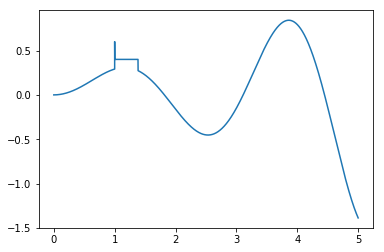

In [79]:
plt.plot(t,ydot)

# C) Run Algorithm

###    [C.1] Model 4th Order System

mean =  7.387646551751262e-06
variance =  9.956740221936448e-05


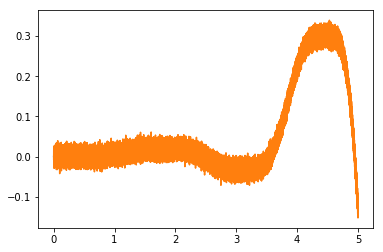

In [28]:
#Define 4th Order TRUE parameters: [a0, a1, a2, a3]
aT = np.array([1.0, 5.0, 5.0, 0.0])

#Define initial conditions
x0 = [0.0, 0.0, 0.0, 1.0]

#Set time interval [a, b] and number of points to generate linear system
a, b, points = 0, 5, 200000

#Set standard deviation for additive white gaussian noise
std = 0.01

#Generate noisy signal yM and noiseless signal yT
yM, yT, t = states_system(a, b, points, x0, aT, std)
#Verify noise is white
print("mean = ", np.mean(yM - yT))
print("variance = ", np.var(yM - yT))
plt.figure()
plt.plot(t,yT)
plt.plot(t,yM)
plt.show()

In [24]:
#Calculate SNR
signal_power = np.mean(np.square(yT))
noise_power = np.mean(np.square(yT - yM))
SNR = signal_power/noise_power
SNR_dB = 10*np.log10(SNR)
print(SNR_dB)

inf


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in double_scalars
  after removing the cwd from sys.path.


In [25]:
# n_max = 6
# knots = 1
# mode = 'mid_point'#"single_random"
# tol = 0.001
# a=0
# b=2
# ak_init = np.array([0.0, 0.0, 0.0, 0.0])
# ak1, aklog1 = RLS(yM, t, a, b, knots, mode, n_max, tol, ak_init)

# Moving window: 

t_window size: 40000
YM_window size: 40000

seed=  0

 t_knots=  0.5000125003125078
0 [0. 0. 0. 1.]

 tk=  0.5000125003125078

 n=  2
tk is 0.5000125003125078
start time  0.5000125003125078

 n=  3
tk is 0.5000125003125078
start time  0.5000125003125078

 n=  4
tk is 0.5000125003125078
start time  0.5000125003125078

 n=  5
tk is 0.5000125003125078
start time  0.5000125003125078
eta [[1.00000000e+00 1.00000000e+00 1.00000000e+00 ... 1.00000000e+00
  1.00000000e+00 1.00000000e+00]
 [0.00000000e+00 2.50006250e-05 5.00012500e-05 ... 9.99949999e-01
  9.99974999e-01 1.00000000e+00]
 [0.00000000e+00 6.25031251e-10 2.50012500e-09 ... 9.99900000e-01
  9.99949999e-01 1.00000000e+00]
 [1.00000000e+00 9.99975000e-01 9.99950000e-01 ... 3.67897836e-01
  3.67888639e-01 3.67879441e-01]]
u: [[ 1.          1.          1.         ...  1.          1.
   1.        ]
 [-1.73205081 -1.7319642  -1.7318776  ...  1.7318776   1.7319642
   1.73205081]
 [ 2.23606797  2.23573256  2.23539717 ...  2.23539717  2.2357

1 [199.82752065 -77.00786111  58.46421131  -3.93821073]
**************Reconstructing signal **********************
eta [[ -3.16243879  -3.16140531  -3.16037166 ...   7.67470949   7.67948785
    7.68426629]
 [ -6.4743554   -6.47512404  -6.47589252 ... -25.75951989 -25.75901895
  -25.75851715]
 [ -2.50713566  -2.50721822  -2.50730077 ...  -0.23807368  -0.23783935
   -0.23760502]
 [  0.89269107   0.89258865   0.89248622 ...  -5.10516045  -5.10525484
   -5.10534922]]
u: [[-0.3033993  -0.30330015 -0.30320098 ...  0.73629931  0.73675774
   0.73721617]
 [-0.4996172  -0.49969477 -0.49977234 ... -2.25038407 -2.25040418
  -2.25042421]
 [-0.99206954 -0.99211648 -0.99216343 ... -0.36227355 -0.36222063
  -0.3621677 ]
 [ 2.08678934  2.08669492  2.08660047 ... -2.79485832 -2.79545626
  -2.79605423]]
YE size: 40000
t_window size: 40000
YM_window size: 40000

seed=  0

 t_knots=  2.5000125003125078
0 [199.82752065 -77.00786111  58.46421131  -3.93821073]

 tk=  2.5000125003125078

 n=  2
tk is 2.5000125

ak is [ 550.64768243 -220.21278415   75.35761849   -5.972412  ] in get_KDSn

***S (Diagonal_Covariance)***
 [[8.43124389e+15 0.00000000e+00 0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.67851626e+18 0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 4.10885013e+20 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 1.25291098e+23]]
******


1 [ 366.44930824 -170.49078207   65.15062318   -5.72911255]
**************Reconstructing signal **********************
eta [[  65.41931166   65.43704038   65.45476826 ...  406.22183357
   406.25823657  406.29462944]
 [ -89.86044263  -89.8521604   -89.84387482 ... -131.59054147
  -131.52477062 -131.45899126]
 [  -7.72079622   -7.73254631   -7.74429726 ... -696.88036746
  -696.87223474 -696.86409819]
 [ 203.22922969  203.23650999  203.24378989 ... -613.56687425
  -613.62945455 -613.69203678]]
u: [[ 0.38223577  0.38233936  0.38244294 ...  2.37349663  2.37370933
   2.37392197]
 [-0.42397298 -0.4239073  -0.42384161 ... -0.27325

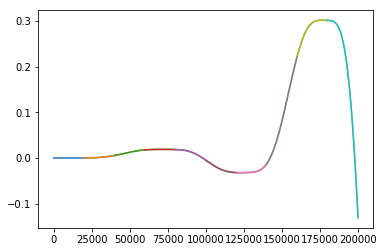

In [27]:
n_max = 6
knots = 1
mode = 'mid_point'#"single_random"
tol = 0.001
window_size=1
end = 5

#for logging
ltv_a=[]
t_window_log=[]
yE_window_log=[]
yM_window_log= []

#initialize
a=0
b = a + window_size
ak1 = np.array([0.0, 0.0, 0.0, 1.0])


while(b <= end):        
    b = a + window_size
    
    #this part is to section the signal into smaller horizons
    t_window = np.where((t>=a) & (t<=b))[0]
    print("t_window size:",t_window.size)
    t_new = np.linspace(a,b,t_window.size)
    yM_window = np.take_along_axis(yM, t_window, 0)
    print("YM_window size:",yM_window.size)
    
    #This is to use the previous estimate as an initial condition to the next one
    ak_init=ak1
    ak1, aklog1 = RLS(yM_window, t_new, a, b, knots, mode, n_max, tol, ak_init)
    print("**************Reconstructing signal **********************")
    yE_1 = get_yE(yM_window, t_new, ak1)
    print("YE size:",yE_1.size)

    #logging and plotting
    ltv_a.append(ak1)
#     yE_window_log.append(yE_log)
    t_window_log.append(t_window)
    plt.plot(t_window, yE_1)
    
    #shift the window by half
    a = a + 0.5

plt.show()

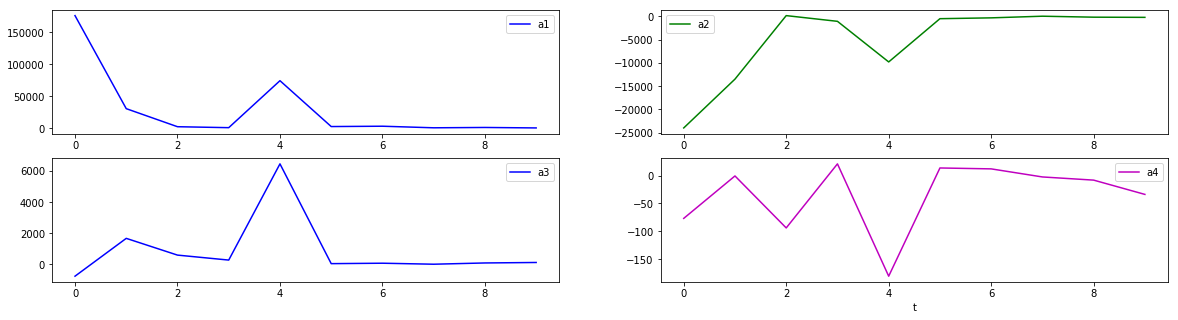

In [104]:
a1_list=[]
a2_list=[]
a3_list=[]
a4_list=[]
for i in range(0,len(ltv_a)):
    a1_list.append(ltv_a[i][0])
    a2_list.append(ltv_a[i][1])
    a3_list.append(ltv_a[i][2])
    a4_list.append(ltv_a[i][3])
t_a = np.arange(0,len(ltv_a),1)
plt.figure(figsize=(20,5))
plt.subplot(2, 2, 1)
plt.plot(t_a, a1_list, 'b', label='a1')
plt.legend(loc='best')
plt.subplot(2, 2, 2)
plt.plot(t_a, a2_list, 'g', label='a2')
plt.legend(loc='best')
plt.subplot(2, 2, 3)
plt.plot(t_a, a3_list, 'b', label='a3')
plt.legend(loc='best')
plt.subplot(2, 2, 4)
plt.plot(t_a, a4_list, 'm', label='a4')
plt.legend(loc='best')
plt.xlabel('t')
plt.show()

In [ ]:
yE_1 = get_yE(yM, t, ak1)
print("estimation:", ak1)

#Plot results
plt.figure(figsize=(8,5))
plt.plot(t, yT, label = "yT")
plt.plot(t, yE_1, label = "yE")
plt.title("Dahleh's RLS Estimation")
plt.xlabel('time')
plt.ylabel('y(t)')
plt.legend()
plt.show()

plt.figure(figsize=(8,5))
plt.plot(t, yM, label = "yM")
plt.plot(t, yT, label = "yT")
plt.plot(t, yE_1, label = "yE")
plt.xlabel('time')
plt.ylabel('y(t)')
plt.legend()
plt.show()

In [ ]:
# a_est=ak1

# xsol = odeint(system_est, x0, t)
# y_est = xsol[:,0]
# ydot_est = xsol[:,1]
# ydotdot_est = xsol[:,2]
# ydotdotdot_est = xsol[:,3]

In [ ]:
# plt.figure(figsize=(10,8))
# plt.plot(t,ynoise)
# plt.plot(t,y)
# plt.plot(t,y_est)

# plt.figure(figsize=(20,5))
# plt.subplot(2, 2, 1)
# plt.plot(t, y, 'b', label='y true')
# plt.plot( t, y_est,'r--', label='y_est')
# plt.legend(loc='best')
# plt.subplot(2, 2, 2)
# plt.plot(t, ydot, 'g', label='dy/dt_true')
# plt.plot(t, ydot_est,'r--', label='dy/dt_est')
# plt.legend(loc='best')
# plt.subplot(2, 2, 3)
# plt.plot(t, ydotdot, 'b', label='d2y/dt2_true')
# plt.plot(t, ydotdot_est,'r--',label='d2y/dt2_est')
# plt.legend(loc='best')
# plt.subplot(2, 2, 4)
# plt.plot(t, ydotdotdot, 'm', label='d3y/dt3_true')
# plt.plot(t, ydotdotdot_est,'r--', label='d3y/dt3_est')
# plt.legend(loc='best')
# plt.xlabel('t')
# plt.show()

In [ ]:
def get_Wk1(Wk, P, S):
    PTS = np.matmul(P.T, S)
    PTSP = np.matmul(PTS, P)
    Wk_inv = np.linalg.inv(Wk)
    Wk1 = np.linalg.inv(Wk_inv + PTSP)
    return Wk1

def get_Kk(Wk1, P, S):
    PTS = np.matmul(P.T, S)
    K = np.matmul(Wk1, PTS)
    return K

def get_ak_1(K, Q, P, ak):
    res = np.array(Q - np.matmul(P, ak))
    
    Kres = np.matmul(K, res)
    
    ak1 = np.array(ak + Kres)
    return ak1

In [ ]:
def RLS_new(y, t, a, b, knots, weight, mode, n_max, tol):
    
    #Set initial iteration
    iteration = 0
    eps = np.inf
    
    #Define Time Points:
    t_knots = get_batch(y, t, knots, iteration, mode)
    
    if t_knots.size == 0:
        print("WARNING! ALGORITHM STOPPED: Mode name incorrectly specified")
        ak, ak_log = None, None
        return ak, ak_log
    
    #Set initial conditions
    ak = np.array([0.0, 0.0, 0.0, 0.0])
    Wk = np.identity(4)*weight
    
    #Store parameter estimation per iteration
    ak_log = np.array(ak)
    
    print(iteration, ak)
    
    while tol < eps:
        
        #Get knots used in current iteration
        tk = get_tk(t_knots, iteration, mode)
        P, Q = get_P_Q(y, t, tk, a, b, n_max)
        
        #Calculate S matrix
        yE = get_yE(y, t, ak)
        var = np.var(y - yE) #Variance Calculation
        
        S = get_S(y, t, tk, a, b, ak, n_max, var)
        #S = np.identity(P.shape[0])
        
        Wk1 = get_Wk1(Wk, P, S)
        K = get_Kk(Wk1, P, S)
        ak1 = get_ak_1(K, Q, P, ak)
            
        eps = np.linalg.norm(ak1 - ak, np.inf)
        
        #Set next iteration
        iteration += 1
        ak = np.array(ak1)
        Wk = np.array(Wk1)

        #Store parameter estimation per iteration
        ak_log = np.vstack((ak_log, ak))
        print(iteration, ak)
        
        #Max iteration:
        if iteration == knots:
            return ak, ak_log
        
    return ak, ak_log

In [ ]:
n_max = 6
knots = 1
# mode = "single_random"
mode = "mid_point"
tol = 0.001
weight = 10000

ak, aklog = RLS_new(yM, t, a, b, knots, weight, mode, n_max, tol)

In [ ]:
yE_new = get_yE(yM, t, ak)
print("estimation:", ak)

#Plot results
plt.figure(figsize=(8,5))
plt.plot(t, yT, label = "yT")
plt.plot(t, yE_new, label = "yE")
plt.title("New RLS Estimation")
plt.xlabel('time')
plt.ylabel('y(t)')
plt.legend()
plt.show()

plt.figure(figsize=(8,5))
plt.plot(t, yM, label = "yM")
plt.plot(t, yT, label = "yT")
plt.plot(t, yE_new, label = "yE")
plt.xlabel('time')
plt.ylabel('y(t)')
plt.legend()
plt.show()

In [ ]:
a_est=ak

xsol = odeint(system_est, x0, t)
y_est = xsol[:,0]
ydot_est = xsol[:,1]
ydotdot_est = xsol[:,2]
ydotdotdot_est = xsol[:,3]

In [ ]:
plt.figure(figsize=(10,8))
plt.plot(t,ynoise)
plt.plot(t,y)
plt.plot(t,y_est)

plt.figure(figsize=(20,5))
plt.subplot(2, 2, 1)
plt.plot(t, y, 'b', label='y true')
plt.plot( t, y_est,'r--', label='y_est')
plt.legend(loc='best')
plt.subplot(2, 2, 2)
plt.plot(t, ydot, 'g', label='dy/dt_true')
plt.plot(t, ydot_est,'r--', label='dy/dt_est')
plt.legend(loc='best')
plt.subplot(2, 2, 3)
plt.plot(t, ydotdot, 'b', label='d2y/dt2_true')
plt.plot(t, ydotdot_est,'r--',label='d2y/dt2_est')
plt.legend(loc='best')
plt.subplot(2, 2, 4)
plt.plot(t, ydotdotdot, 'm', label='d3y/dt3_true')
plt.plot(t, ydotdotdot_est,'r--', label='d3y/dt3_est')
plt.legend(loc='best')
plt.xlabel('t')
plt.show()

In [ ]:
print("Dahleh's estimation:", aklog1[-1])
print("New RLS estimation:", aklog[-1])

fig, axs = plt.subplots(2, 2, figsize=(15,8))
axs[0, 0].plot(np.arange(0, aklog.shape[0]), aklog[:,0], label = "a0 - new RLS")
axs[0, 0].plot(np.arange(0, aklog1.shape[0]), aklog1[:,0], label = "a0 - Dahleh's")
axs[0, 0].set_title('a0')
axs[0, 1].plot(np.arange(0, aklog.shape[0]), aklog[:,1], label = "a1 - new RLS")
axs[0, 1].plot(np.arange(0, aklog1.shape[0]), aklog1[:,1], label = "a1 - Dahleh's")
axs[0, 1].set_title('a1')
axs[1, 0].plot(np.arange(0, aklog.shape[0]), aklog[:,2], label = "a2 - new RLS")
axs[1, 0].plot(np.arange(0, aklog1.shape[0]), aklog1[:,2], label = "a2 - Dahleh's")
axs[1, 0].set_title('a2')
axs[1, 1].plot(np.arange(0, aklog.shape[0]), aklog[:,3], label = "a3 - new RLS")
axs[1, 1].plot(np.arange(0, aklog1.shape[0]), aklog1[:,3], label = "a3 - Dahleh's")
axs[1, 1].set_title('a3')

for ax in axs.flat:
    ax.set(xlabel='iterations', ylabel='a(n)')
    ax.legend()

# Hide x labels and tick labels for top plots and y ticks for right plots.
#for ax in axs.flat:
#    ax.label_outer()
    

In [ ]:
#Plot results
plt.figure(figsize=(8,5))
plt.plot(t, yT, label = "yT")
plt.plot(t, yE_1, label = "yE Dahleh's")
plt.plot(t, yE_new, label = "yE new RLS")
plt.title("New RLS Estimation")
plt.xlabel('time')
plt.ylabel('y(t)')
plt.legend()
plt.show()

plt.figure(figsize=(8,5))
plt.plot(t, yM, label = "yM")
plt.plot(t, yT, label = "yT")
plt.plot(t, yE_1, label = "yE Dahleh's")
plt.plot(t, yE_new, label = "yE new RLS")
plt.xlabel('time')
plt.ylabel('y(t)')
plt.legend()
plt.show()

In [ ]:
# result = []
# for t in t_knots_trial:
#     t = int(t)
#     Orig_vs_d = abs(yT[t] - yE_1[t])
#     Orig_vs_new = abs(yT[t] - yE_new[t])
#     result.append([Orig_vs_d, Orig_vs_new])

In [ ]:
result = []

t_trial = int(tk)
Orig_vs_d = abs(yT[t_trial] - yE_1[t_trial])
Orig_vs_new = abs(yT[t_trial] - yE_new[t_trial])
result.append([Orig_vs_d, Orig_vs_new])